<a href="https://colab.research.google.com/github/vasudev-sharma/Flixstock-assignment/blob/master/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# PyTorch libraries
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import os
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import math
import random
from tqdm import tqdm
import shutil

In [1]:
!pip install wandb
# Visulazing the training logs, metrics and artifacts
import wandb



     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 174kB 35.4MB/s 
     |████████████████████████████████| 133kB 37.2MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=6ac003cad452693688780fbc8ba68c2ee839f8479866e9a5e27913b5b368c9ea
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=b3579ee9a4bb4175d7bc801e7b57b56bfa0602f538c2b31d9336ab6b5ccd24bf
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


# Preparing the data

In [3]:
# Download the data
!FILEID='1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j' && \
FILENAME='data.zip' && \
FILEDEST="https://docs.google.com/uc?export=download&id=${FILEID}" && \
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate ${FILEDEST} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${FILEID}" -O $FILENAME && rm -rf /tmp/cookies.txt

--2021-06-15 12:29:43--  https://docs.google.com/uc?export=download&id=1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j
Resolving docs.google.com (docs.google.com)... 64.233.189.139, 64.233.189.102, 64.233.189.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-06-15 12:29:43 (45.3 MB/s) - written to stdout [3300]

--2021-06-15 12:29:43--  https://docs.google.com/uc?export=download&confirm=6Lrp&id=1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j
Resolving docs.google.com (docs.google.com)... 64.233.189.100, 64.233.189.101, 64.233.189.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-78-docs.googleusercontent.com/docs/securesc/799ugto2fg97dphm9nbedh0rouihpg85/matuunc95k

In [4]:
# unzip the data
%%bash
unzip data.zip -d data


Archive:  data.zip
   creating: data/classification-assignment/
  inflating: data/__MACOSX/._classification-assignment  
   creating: data/classification-assignment/images/
  inflating: data/__MACOSX/classification-assignment/._images  
  inflating: data/classification-assignment/attributes.csv  
  inflating: data/__MACOSX/classification-assignment/._attributes.csv  
  inflating: data/classification-assignment/images/11523001185834-Masch-Sports-Mens-Polyester-Printed--Colourblocked-T-Shirts---Pack-of-2-8971523001185724-4.jpg  
  inflating: data/__MACOSX/classification-assignment/images/._11523001185834-Masch-Sports-Mens-Polyester-Printed--Colourblocked-T-Shirts---Pack-of-2-8971523001185724-4.jpg  
  inflating: data/classification-assignment/images/11491549671402-PUMA-White-FIGC-Italia-Away-Polyester-T-shirt-7541491549671229-3.jpg  
  inflating: data/__MACOSX/classification-assignment/images/._11491549671402-PUMA-White-FIGC-Italia-Away-Polyester-T-shirt-7541491549671229-3.jpg  
  inflat

In [5]:
data_path = Path('/content/data/classification-assignment')

In [6]:
# Remove `Thumbs.db` file from images directory if exsists

path_file = data_path / 'images' / 'Thumbs.db'
if os.path.exists(str(path_file)):
  print("The file exists")
  os.unlink(str(path_file))
  print('Thumbs.db file has been removed')

The file exists
Thumbs.db file has been removed


## Datasets and DataLoaders

In [37]:
class FashionDataset(Dataset):
  def __init__(self, root, transform=None, target_transform=None):
    
    self.root = root
    self.transform = transform
    self.target_transform = target_transform
    self.samples = os.listdir(str(self.root / 'images'))

    # Attributes dataframe
    self.df_attributes = pd.read_csv(str(self.root / 'attributes.csv'))

    # Encode each attribute into one-hot encoding, and then concatenate the encoded labels to get targets
    self.preprocess_targets() 

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, index):

    # shuffle the images list
    np.random.shuffle(self.samples)

    # name of the image
    filename_image = self.samples[index]

    try:
      image = Image.open(str(self.root / 'images' / filename_image)).convert('RGB')
    except Exception as e:
      print('Path of the image is', str(self.root / 'images' / filename_image))
      print('Unable to read the image')

    # retreive the specific row of given index
    df_row = self.df_attributes.loc[self.df_attributes['filename'] == filename_image]

    if self.transform is not None:
      image = self.transform(image)

    # Target
    target_start_idx = self.df_attributes.columns.get_loc('neck_0.0')
    target = torch.tensor(self.df_attributes.iloc[0].tolist()[target_start_idx:], dtype=torch.float32)

    # return target and labels
    return image, target
  
  def preprocess_targets(self):

    # Drop rows which have `NA`
    # TODO: Look at optimal ways of reducing bias
    self.df_attributes = self.df_attributes.dropna()

    # one hot encode the Neck attribute
    one_hot_neck = pd.get_dummies(self.df_attributes.neck, prefix='neck')

    # one hot encode the sleeve_length attribute
    one_hot_sleeve_length = pd.get_dummies(self.df_attributes.sleeve_length, prefix='sleeve_length')

    # one hot encode the pattern attribute
    one_hot_pattern = pd.get_dummies(self.df_attributes.pattern, prefix='pattern')

    # concatenate the one hot encoded attributes to dataframe
    self.df_attributes = pd.concat([self.df_attributes, one_hot_neck, one_hot_sleeve_length, one_hot_pattern], axis=1)

  def getImagesList(self):
    return self.samples


In [38]:
# transforms 
train_transforms =  transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
      )

valid_transforms = transforms.Compose(
          [transforms.Resize((256, 256)),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ]
          )


In [39]:
# Dataset

dataset = FashionDataset(data_path, transform=train_transforms)
list_images = dataset.getImagesList()

In [40]:
# split of dataset into train, valid, test datasets

train_split = 0.75
val_split = 0.15
test_split = 1 - (train_split + val_split)

len_train_dataset = math.ceil(train_split * len(dataset))
len_val_dataset = math.ceil(val_split * len(dataset))
len_test_dataset = len(dataset) - (len_train_dataset + len_val_dataset)


In [41]:
ds_train, ds_valid, ds_test = random_split(dataset, [len_train_dataset, len_val_dataset, len_test_dataset])

In [42]:
# sanity check 
assert len(ds_train) == len_train_dataset
assert len(ds_valid) == len_val_dataset
assert len(ds_test) == len_test_dataset

# Test directory

In [43]:
# Test directory for testing the images
# Test directory containes all the images for testing the model

try:
  os.mkdir(str(data_path / 'test'))
except Exception as e:
  print('The directory already exists')

# Save test images in `test` directory
for index, image_name in tqdm(enumerate(list_images)):
  if index in ds_test.indices:
    shutil.copy(str(data_path / 'images' / image_name), str(data_path / 'test' / image_name))




1782it [00:00, 37250.00it/s]

The directory already exists


In [44]:
# zip the test data for downloading
%%bash
cd data/classification-assignment
zip -r test.zip test

# Note this test data has been uploaded to Gdrive

updating: test/ (stored 0%)
updating: test/11511934404070-Teesort-Mens-Solid-V-Neck-T-shirt-8551511934404052-4.jpg (deflated 4%)
updating: test/11522490608947-sOliver-Men-Grey-Solid-V-Neck-T-shirt-2921522490608785-3.jpg (deflated 1%)
updating: test/242f0bc2-70a4-4150-abf7-b6c90b543c811537267422891-GAP-Mens-Multicolor-Stripe-Polo-T-Shirt-6691537267421759-5.jpg (deflated 1%)
updating: test/11517383934877-Alcis-Men-Solid-Blue-Polo-T-Shirt-4701517383934802-4.jpg (deflated 1%)
updating: test/11517829231394-HRX-by-Hrithik-Roshan-Charcoal-Grey-Active-Hooded-T-Shirt-7151517829231291-2.jpg (deflated 1%)
updating: test/11516187597844-Proline-Active-Men-Grey-Melange-Colourblocked-Polo-Collar-T-shirt-9431516187597765-3.jpg (deflated 1%)
updating: test/11522228263009-Adidas-Men-WC-LOGOTYPE-7131522228262882-3.jpg (deflated 1%)
updating: test/11517826112517-HRX-by-Hrithik-Roshan-Grey-Solid-T-shirt-4091517826112479-5.jpg (deflated 1%)
updating: test/11514525738247-ESPRIT-Men-Tshirts-7871514525738155-1

# Hyperparameters

In [59]:
# hyperparameters
batch_size = 16
lr = 5e-5
epochs=30
log_freq = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_labels = 21



In [60]:
model_dict = {
    # DenseNet
    'densenet121': 1024,
    'densenet169': 1664,
    'densenet161': 2208,

    # ResNet
    'resnet50': 2048,
    'resnet101' : 2048,
    'resnet34': 512,

    # EfficientNet
    'efficientnet-b0':1280,
    'efficientnet-b3': 1536,
    'efficientnet-b5': 2048

}


model_name = 'efficientnet-b3'
# Change the model name depending which model you want to fine tune

In [61]:
device

device(type='cuda', index=0)

## Dataloaders

In [62]:
# Dataloaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_valid, batch_size=len(ds_test), shuffle=False, pin_memory=True)

In [63]:
# sanity check the shape 
for batch in dl_train:
  img_batch, target_batch = batch
  print(img_batch.shape)
  print(target_batch.shape)
  break

torch.Size([16, 3, 256, 256])
torch.Size([16, 21])


In [64]:
#@title
!wandb login 202040aaac395bbf5a4a47d433a5335b74b7fb0e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Model Training

In [65]:
# efficient net model -> https://github.com/lukemelas/EfficientNet-PyTorch
!pip install efficientnet_pytorch

In [66]:
# load a pretrained Densenet 121 model for finetuing on the Chest X_ray images
from efficientnet_pytorch import EfficientNet

if not model_name.startswith('efficientnet'):
  model = torch.hub.load('pytorch/vision:v0.9.0', model_name, pretrained=True)
else:
  model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b3


In [67]:
# Densenet 
if model_name.startswith('densenet'): 
  model.classifier = nn.Linear(model_dict[model_name], n_labels)

if model_name.startswith('efficientnet'):
  print(model_dict[model_name])
  model._fc = nn.Linear(model_dict[model_name], n_labels)
else:
  model.fc = nn.Linear(model_dict[model_name], n_labels)

# Migrate the mode to device
model.to(device)

1536


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

## Model Loss, Optmizer and Scheduler

In [68]:
# 
model.loss_func = nn.BCELoss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=5)

In [69]:
from sklearn.metrics import *

In [70]:
def calculate_metrics(pred, target, threshold=0.5):
  pred = np.array(pred > threshold, dtype = float)
  return { 
      # Micro scores
      'micro/precision':precision_score(y_true=target, y_pred=pred, average='micro'),
      'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
      'micro/f1_score': f1_score(y_true=target, y_pred=pred, average='micro'),

      # Macro scores
      'macro/precision':precision_score(y_true=target, y_pred=pred, average='macro'),
      'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
      'macro/f1_score': f1_score(y_true=target, y_pred=pred, average='macro'),

  }

In [71]:

def train_model(model, dl_train, dl_valid, epochs, log_freq):
  print('***************Training of the model has started**************')
  wandb.watch(model, log='all')

  iteration = 0
  for epoch in range(epochs+1):

    batch_losses = []
    preds_list = []
    targets_list = []
    for batch_idx, (features, targets) in enumerate(dl_train, 1):
      model.train()
      
      model.optimizer.zero_grad()

      # Migrate the features and targets to device
      features, targets = features.to(device), targets.to(device)

      # Forward pass
      logits = model(features)
      preds = torch.sigmoid(logits)

      # loss
      loss = model.loss_func(preds, targets)

      # metrics
      preds_list.extend(preds.cpu().detach().numpy())
      targets_list.extend(targets.cpu().detach().numpy())

      # backward pass
      loss.backward()

      # update weights
      model.optimizer.step()

      batch_losses.append(loss.item())
    
    loss_mean = np.mean(batch_losses)
    metrics_dict = calculate_metrics(np.array(preds_list), np.array(targets_list))
    
    print('[Epoch = % d]: train_loss = %.3f,  micro/precision = %.3f, micro/recall = %.3f, micro/f1_score = %.3f, macro/precision = %.3f, macro/recall = %.3f, macro/f1_score = %.3f' \
          % (epoch, loss_mean , metrics_dict['micro/precision'], metrics_dict['micro/recall'], metrics_dict['micro/f1_score'], metrics_dict['macro/precision'], metrics_dict['macro/recall'], metrics_dict['macro/f1_score']))

    print('====='*12)
    print('\n')

    # Validation 
    model.eval()
    with torch.no_grad():

      val_preds_list = []
      val_targets_list = []
      val_loss_sum = 0.0
      for val_batch_idx, (val_features, val_targets) in enumerate(dl_valid, 1):
          
          val_features, val_targets = val_features.to(device), val_targets.to(device)
          
          # Forward pass
          val_logits = model(val_features)
          val_preds = torch.sigmoid(val_logits)

          val_preds_list.extend(val_preds.cpu().numpy())
          val_targets_list.extend(val_targets.cpu().numpy())

          # val loss
          val_loss = model.loss_func(val_preds, val_targets).item()
          val_loss_sum+=val_loss

    val_metrics_dict = calculate_metrics(np.array(val_preds_list), np.array(val_targets_list))


    print('-> [Epoch = % d]: val_loss = %.3f,  val_micro/precision = %.3f, val_micro/recall = %.3f, val_micro/f1_score = %.3f, val_macro/precision = %.3f, val_macro/recall = %.3f, val_macro/f1_score = %.3f' \
          % (epoch, val_loss_sum / val_batch_idx, val_metrics_dict['micro/precision'], val_metrics_dict['micro/recall'], val_metrics_dict['micro/f1_score'], val_metrics_dict['macro/precision'], val_metrics_dict['macro/recall'], val_metrics_dict['macro/f1_score']))
    print('----'*12)
    print('\n')

    wandb.log({'epoch': epoch,
               'train_loss': loss_mean,
               'train_micro_precision': metrics_dict['micro/precision'],
                'train_micro_recall':metrics_dict['micro/recall'],
                'train_micro_f1_score': metrics_dict['micro/f1_score'],
                'train_macro_precision':metrics_dict['macro/precision'],
                'train_macro_recall': metrics_dict['macro/recall'],
                 'train_macro_f1_score': metrics_dict['macro/f1_score'],
                 'val_loss' : val_loss_sum / val_batch_idx,
                'val_micro_precision': val_metrics_dict['micro/precision'],
                'val_micro_recall': val_metrics_dict['micro/recall'],
                'val_micro_f1_score': val_metrics_dict['micro/f1_score'],
                'val_macro_precision': val_metrics_dict['macro/precision'],
                'val_macro_recall': val_metrics_dict['macro/recall'],
                'val_macro_f1_score': val_metrics_dict['macro/f1_score']

              })

  
  print('****************Model training completed******************')
  torch.save(model.state_dict(), model_name + '.h5')




In [ ]:
%%wandb

def main():
  # wandb initialize a new run
  wandb.init(project='Flixstock-assignment')
  wandb.watch_called = False

  config = wandb.config
  config.batch_size = batch_size
  config.epochs = epochs
  config.lr = lr
  config.seed = 42
  config.labels = n_labels
  config.device = device
  config.model_name = model_name
  config.log_freq = log_freq

  # set seed and set cuddn to deterministic for reproducible results
  torch.manual_seed(config.seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  np.random.seed(config.seed)
  random.seed(config.seed)

  # train the model
  train_model(model, dl_train, dl_valid, epochs, log_freq)

 
if __name__=='__main__':
  main()
  wandb.finish()

epoch,7
train_loss,0.00536
train_micro_precision,1.0
train_micro_recall,1.0
train_micro_f1_score,1.0
train_macro_precision,0.14286
train_macro_recall,0.14286
train_macro_f1_score,0.14286
val_loss,0.00471
val_micro_precision,1.0
val_micro_recall,1.0


epoch,▁▂▃▄▅▆▇█
train_loss,█▃▂▁▁▁▁▁
train_micro_precision,▁███████
train_micro_recall,▁███████
train_micro_f1_score,▁███████
train_macro_precision,▁▁▁▁▁▁▁▁
train_macro_recall,▁███████
train_macro_f1_score,▁███████
val_loss,█▃▂▂▁▁▁▁
val_micro_precision,▁▁▁▁▁▁▁▁
val_micro_recall,▁▁▁▁▁▁▁▁


***************Training of the model has started**************


To retrain the model, or play with hyperparameters, pretrained models, make the necessary changes in the cells. 

Then instead of executing all the cells, only run the runs after cell https://colab.research.google.com/github/vasudev-sharma/Flixstock-assignment/blob/master/Assignment.ipynb?authuser=3#scrollTo=LmVitCVOCBxf

## Logging the models: Weights and Biases
Kindly refer this link to view the training logs, metrics, and artifacts :-> https://wandb.ai/vs74/Flixstock-assignment

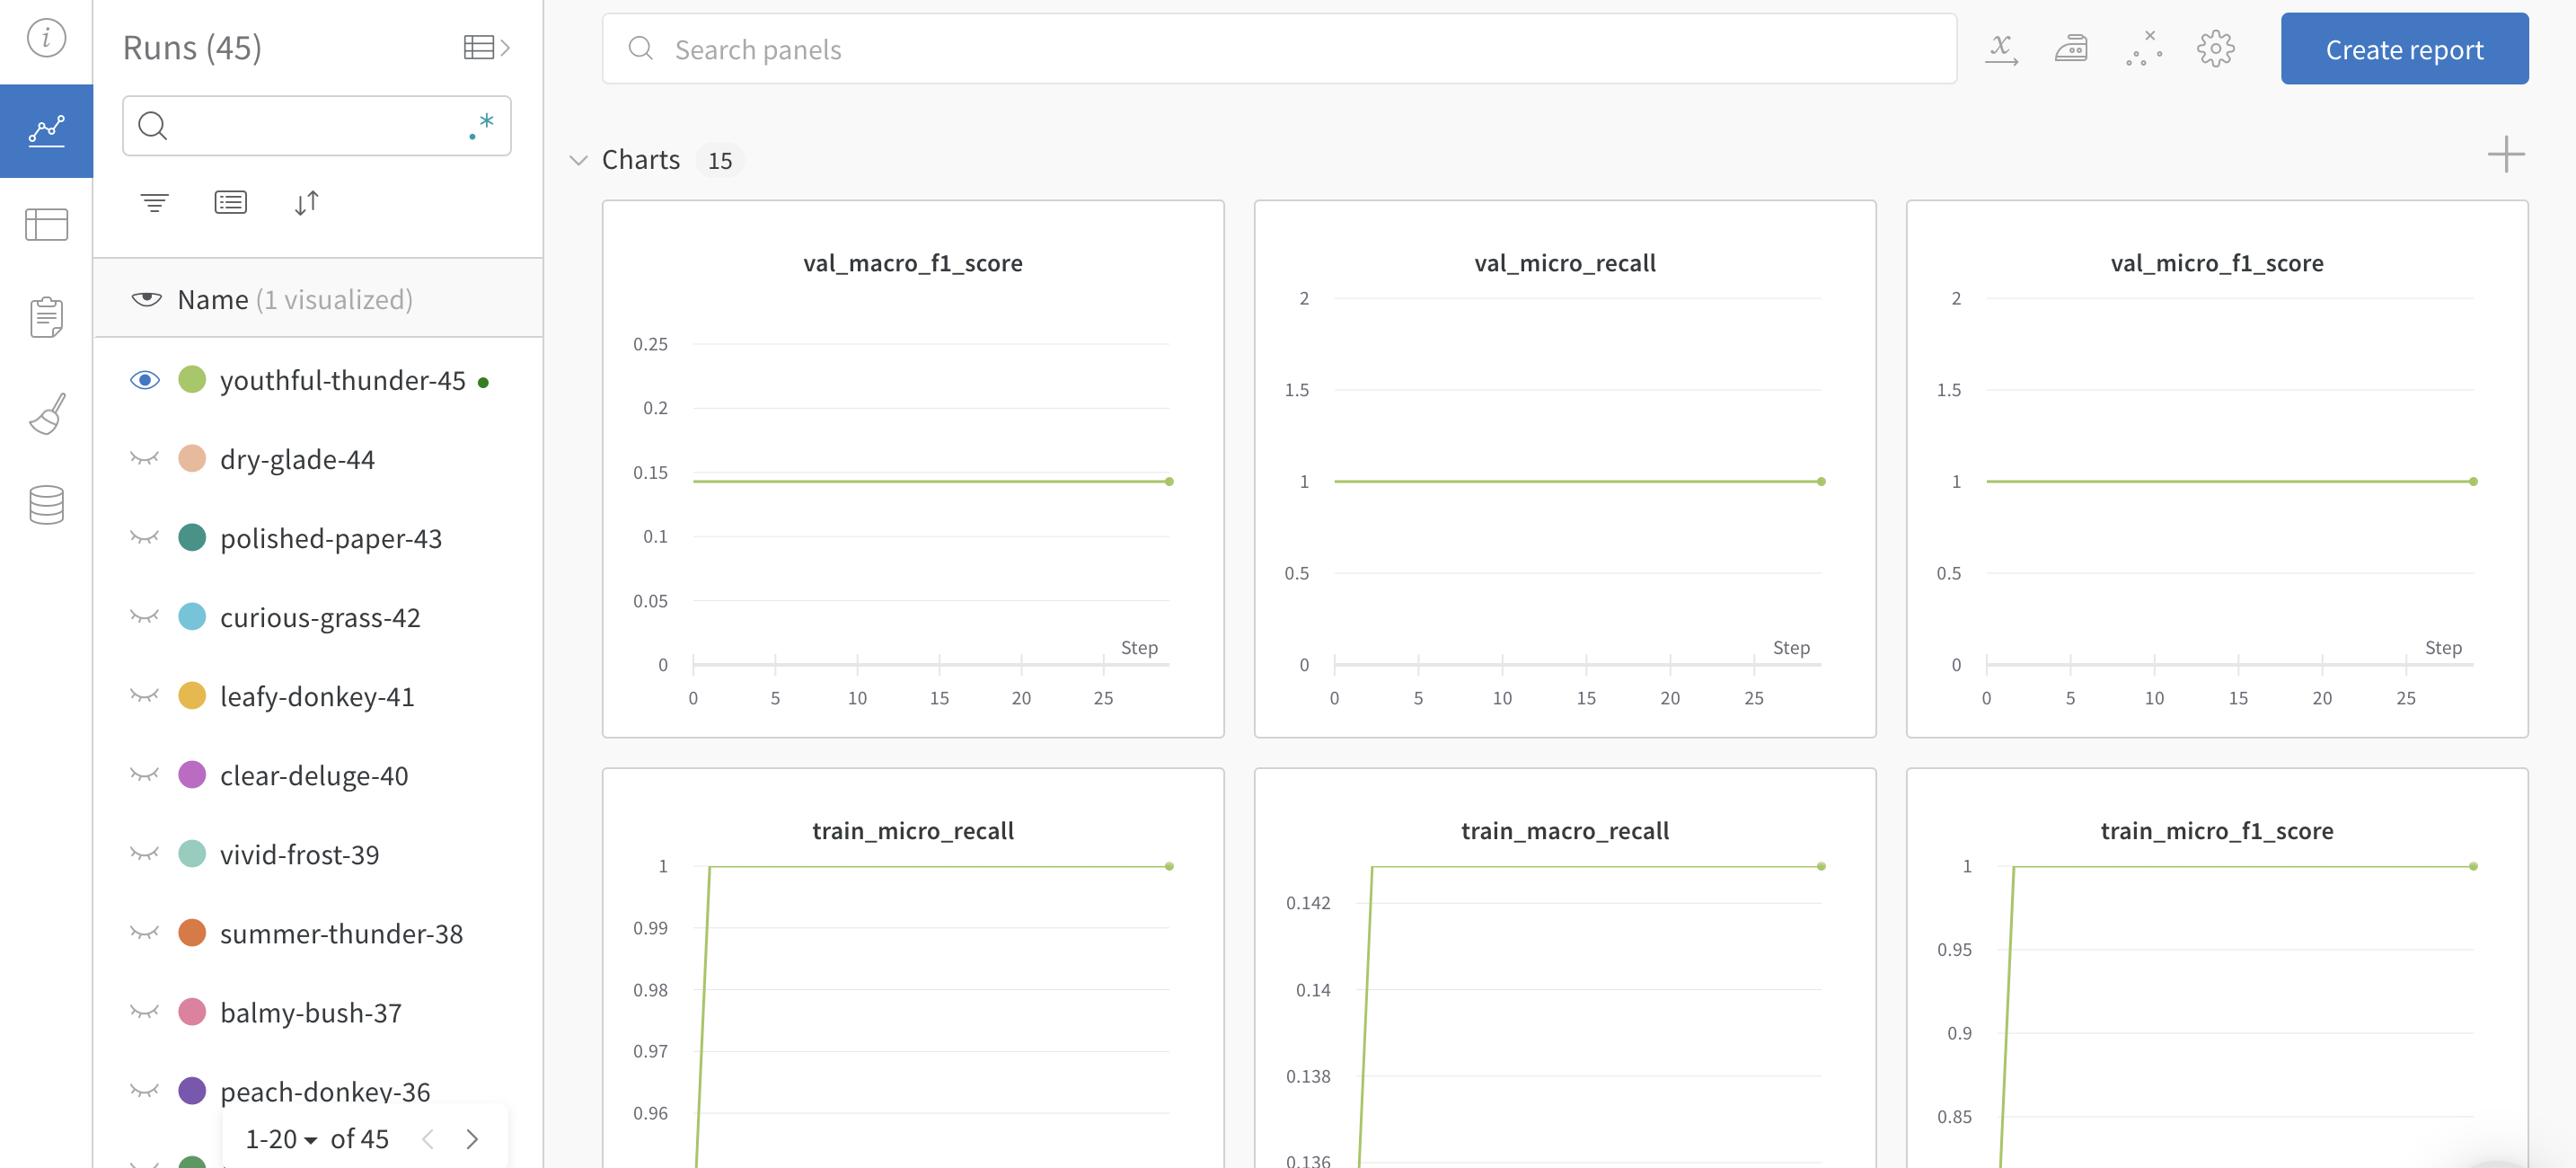